In [8]:
#getting the labelled data
rawDf= panda.read_csv ("raw_news_kaggle.csv")
rawDf

,label,header,url,text
0,Shooting,Ibadan Lounge-Bar Shooting Controversy: Soldie...,https://saharareporters.com/2018/03/08/ibadan-...,"Claims that last week’s shooting, which led to..."
1,Theft,"Oil Theft Reduced To 40,000 Barrels Per Day, S...",https://saharareporters.com/2014/01/03/oil-the...,Governor Emmanuel Uduaghan of Nigeria’s Delta ...
2,Shooting,"Embattled Nigerian Singer, Tiwa Savage Release...",https://saharareporters.com/2021/10/20/embattl...,She also accompanied the video with a terse po...
3,Shooting,BREAKING: Shooting Reported At Polling Unit In...,https://saharareporters.com/2020/10/10/breakin...,"The shooting took place at Polling Unit 11, Ok..."
4,Bribery,"BREAKING: Nigeria's Ex-Petroleum Minister, Die...",https://saharareporters.com/2013/02/01/photone...,House of representatives member Farouk Lawan t...
...,...,...,...,...
95,Shooting,Ilorin: Students Resume March Over Shooting of...,https://saharareporters.com/2013/05/28/ilorin-...,"Students of the College of Education, Kwara St..."
96,Shooting,"Igbo People Calling Nigeria Zoo, Shooting Civi...",https://saharareporters.com/2022/09/30/igbo-pe...,He added that the people of the South East reg...
97,Rape,"Ekiti First Lady, Bisi Fayemi’s Security Aide ...",https://saharareporters.com/2021/07/14/ekiti-f...,"According to Fapohunda, the alleged rape incid..."
98,Bribery,Delta House Speaker Monday Igbuya Implicated I...,https://saharareporters.com/2015/08/04/delta-h...,An N2.4 million bribery scam is rocking the De...


In [6]:
import pandas as panda
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn
#from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [110]:
#DATA Colection
import requests
from bs4 import BeautifulSoup
import json
import urllib.request,sys,time

columns = ['Category','Link'] 
df = panda.DataFrame(columns = columns)  # initialize an empty dataframe with column names
base_url = 'https://nigeriacrime.com/'

categories =  ['kidnapping','murder', 'fraud', 'domestic-violence', 'abuse',]  # news categories we are interested in

'''Search through each news based category in nigeriacrime website and for each news article, extract the url and append it to the dataframe'''
for cat in categories:
  for page_number in range(1, 10):
    url = base_url + cat + '/'  if page_number == 1 else base_url + cat + '/' + 'page/'+str(page_number) + '/'
    try:
      page=requests.get(url) 
    except Exception as e:    
      error_type, error_obj, error_info = sys.exc_info()      
      print ('ERROR FOR LINK:',url)               
      print (error_type, 'Line:', error_info.tb_lineno)
      continue
    if page.status_code == 200:
      soup = BeautifulSoup(page.text, "html.parser")
      articles = soup.find_all('div',attrs={'class':'td-module-thumb'})
      for article in articles:
        nurl = article.find("a")
        nurl = nurl.get("href")

          # ... your code to extract data (replace with actual data)
        data = {'Category': cat, 'Link': nurl}
          # Create a single-row DataFrame from the data
        new_row_df = panda.DataFrame(data, index=[0])  # Create a single-row DataFrame

        # Concatenate the existing DataFrame with the new row DataFrame
        df = panda.concat([df, new_row_df], ignore_index=True)
       
    # check progress 
    if page_number % 5 == 0:
        print(cat, page_number)

kidnapping 5
murder 5
fraud 5
domestic-violence 5
abuse 5


In [111]:
df.shape

(3168, 2)

In [112]:
df.to_csv('newsPage_extract.csv')
df

,Category,Link
0,murder,https://nigeriacrime.com/n60-million-fraud-sus...
1,murder,https://nigeriacrime.com/police-officers-rejec...
2,murder,https://nigeriacrime.com/fire-engulfs-househol...
3,murder,https://nigeriacrime.com/nursing-mother-grandm...
4,murder,https://nigeriacrime.com/5-bag-death-sentence-...
...,...,...
3163,abuse,https://nigeriacrime.com/nscdc-nab-2-electrici...
3164,abuse,https://nigeriacrime.com/man-escapes-jungle-ju...
3165,abuse,https://nigeriacrime.com/protect-your-home-fam...
3166,abuse,https://nigeriacrime.com/human-trafficking-one...


In [107]:
df['Link']

Series([], Name: Link, dtype: object)

In [113]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import sys  # For error handling

def extract_news_from_url(url):
  """Fetches a URL, extracts news data (date, text), and handles errors.

  Args:
      url: The URL of the news page.

  Returns:
      A dictionary containing extracted data ('Date': date, 'News': news) or None if an error occurs.
  """
  try:
    response = requests.get(url)
    response.raise_for_status()  # Raise an error for failed requests
    soup = BeautifulSoup(response.content, 'html.parser')

    date_element = soup.find('time', class_='entry-date updated td-module-date')
    date = date_element.text.strip() if date_element else "kol"

    # Improved news text extraction (consider adjusting selectors)
    text_elements = soup.find_all('div', class_='tdb-block-inner td-fix-index')
    news = text_elements.find('p').get_text()
    # news = ' '.join([element.get_text(strip=True) for element in text_elements])

    return {'Date': date, 'News': news}
  except requests.exceptions.RequestException as e:
    print(f"Error fetching {url}: {e}")
    return None


def main():
  try:
    # Read CSV data assuming 'Link' is the column containing URLs
    df = panda.read_csv('newsPage_extract.csv')

    # Create an empty DataFrame to store extracted data
    extracted_data = []

    for index, row in df.iterrows():
        url = row['link']
        extracted_news = extract_news_from_url(url)
        df.at[index, 'text'] = extracted_news
        if extracted_news:
            extracted_data.append(extracted_news)
        else:
            print(f"Error extracting data from {url}")

    # Create a new DataFrame from the extracted data
    new_df = panda.DataFrame(extracted_data)

    # Append the new DataFrame to the original (consider alternatives if preferred)
    # df = pd.concat([df, new_df], ignore_index=True)  # One option to add new data to original DataFrame

    # Write the new DataFrame (or updated original DataFrame) to a CSV
    new_df.to_csv('output_file.csv', index=False)

  except Exception as e:
    print(f"An unexpected error occurred: {e}")


if __name__ == "__main__":
  main()


An unexpected error occurred: 'link'


In [105]:
new_d=pd.read_csv('output_file.csv')

EmptyDataError: No columns to parse from file

In [9]:
rawDf.isna().sum()

label     0
header    0
url       0
text      0
dtype: int64

In [10]:
# dropping 'url' and 'header' column
columns_to_drop = ['header', 'url']
df1 = rawDf.drop(columns=columns_to_drop)
df1.to_csv('labelled_crime.csv', index=False)

In [11]:
rawDf

,label,header,url,text
0,Shooting,Ibadan Lounge-Bar Shooting Controversy: Soldie...,https://saharareporters.com/2018/03/08/ibadan-...,"Claims that last week’s shooting, which led to..."
1,Theft,"Oil Theft Reduced To 40,000 Barrels Per Day, S...",https://saharareporters.com/2014/01/03/oil-the...,Governor Emmanuel Uduaghan of Nigeria’s Delta ...
2,Shooting,"Embattled Nigerian Singer, Tiwa Savage Release...",https://saharareporters.com/2021/10/20/embattl...,She also accompanied the video with a terse po...
3,Shooting,BREAKING: Shooting Reported At Polling Unit In...,https://saharareporters.com/2020/10/10/breakin...,"The shooting took place at Polling Unit 11, Ok..."
4,Bribery,"BREAKING: Nigeria's Ex-Petroleum Minister, Die...",https://saharareporters.com/2013/02/01/photone...,House of representatives member Farouk Lawan t...
...,...,...,...,...
95,Shooting,Ilorin: Students Resume March Over Shooting of...,https://saharareporters.com/2013/05/28/ilorin-...,"Students of the College of Education, Kwara St..."
96,Shooting,"Igbo People Calling Nigeria Zoo, Shooting Civi...",https://saharareporters.com/2022/09/30/igbo-pe...,He added that the people of the South East reg...
97,Rape,"Ekiti First Lady, Bisi Fayemi’s Security Aide ...",https://saharareporters.com/2021/07/14/ekiti-f...,"According to Fapohunda, the alleged rape incid..."
98,Bribery,Delta House Speaker Monday Igbuya Implicated I...,https://saharareporters.com/2015/08/04/delta-h...,An N2.4 million bribery scam is rocking the De...


In [12]:
df1

,label,text
0,Shooting,"Claims that last week’s shooting, which led to..."
1,Theft,Governor Emmanuel Uduaghan of Nigeria’s Delta ...
2,Shooting,She also accompanied the video with a terse po...
3,Shooting,"The shooting took place at Polling Unit 11, Ok..."
4,Bribery,House of representatives member Farouk Lawan t...
...,...,...
95,Shooting,"Students of the College of Education, Kwara St..."
96,Shooting,He added that the people of the South East reg...
97,Rape,"According to Fapohunda, the alleged rape incid..."
98,Bribery,An N2.4 million bribery scam is rocking the De...


In [34]:
# Stopwords removal
stopwords = nltk.corpus.stopwords.words("english")

stemmer = PorterStemmer()
# custom data cleaning function

def news_clean(text):
    pNews = text
    pNews = pNews.lower()  # Convert to lowercase for case-insensitive processing

    # Remove URLs 
    pNews = re.sub(r"http\S+", "", pNews)

    # Remove extra whitespaces
    pNews = re.sub(r"\s+", " ", pNews).strip()

    # Remove numbers
    pNews = re.sub(r"\d+(\.\d+)?", "", pNews)

    # Remove special characters 
    pNews = re.sub(r"[^\w\s]", "", pNews)

    # Convert the list to a Series
    pNews = panda.Series(pNews, name='processed_news')
    
     # tokenizing
    pNews = pNews.apply(lambda x: x.split())
    
     # removal of stopwords
    pNews=  pNews.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the news text
    pNews = pNews.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(pNews)):
        pNews[i] = ' '.join(pNews[i])
    
    return pNews

In [40]:
# Apply cleaning to the news column 
df1["processed_news"] = df1["text"].apply(news_clean)  
# Save the cleaned dataset
df1.to_csv("clean_label_news2.csv", index=False)

In [41]:
df2= panda.read_csv("clean_label_news2.csv")
#drop unprocessed text to save memory
column_to_drop = 'text'  

# Drop the column from the DataFrame
df2 = df2.drop(column_to_drop, axis=1)

# Save the modified DataFrame back to the same CSV file, overwriting it
df2.to_csv('clean_label_news2.csv', index=False)

In [43]:
df2.head(20)

,label,processed_news
0,Shooting,claim that last week shoot which led to the de...
1,Theft,governor emmanuel uduaghan of nigeria delta st...
2,Shooting,she also accompani the video with a ters post ...
3,Shooting,the shoot took place at poll unit okeijebu aku...
4,Bribery,hous of repres member farouk lawan today arrai...
5,Arson,the ondo state chapter of the labour parti lp ...
6,Rape,the lawmak seem to be persist on continu with ...
7,Rape,the law enforc agent should not shirk their re...
8,Theft,it ha therefor demand a stiff and decis action...
9,Rape,becaus let face it how els can you rationalis ...


In [19]:
pip install wordcloud


   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/300.2 kB ? eta -:--:--
   ------- ------------------------------- 61.4/300.2 kB 544.7 kB/s eta 0:00:01
   --------- ----------------------------- 71.7/300.2 kB 491.5 kB/s eta 0:00:01
   ------------ ------------------------- 102.4/300.2 kB 420.8 kB/s eta 0:00:01
   ------------------- ------------------ 153.6/300.2 kB 482.7 kB/s eta 0:00:01
   ----------------------- -------------- 184.3/300.2 kB 506.0 kB/s eta 0:00:01
   ----------------------------- -------- 235.5/300.2 kB 576.2 kB/s eta 0:00:01
   -------------------------------------  297.0/300.2 kB 611.3 kB/s eta 0:00:01
   -------------------------------------  297.0/300.2 kB 611.3 kB/s eta 0:00:01
   -------------------------------------  297.0/300.2 kB 611.3 kB/s eta 0:00:01
   -------------------------------------- 300.2/300.2 kB 452.3 kB/s eta 0:00:00


In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


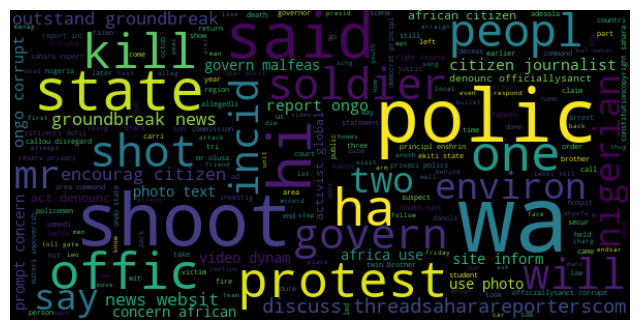

In [45]:
# visualizing which of the word is most commonly used for shooting crimes
shooting_words = ' '.join([text for text in df2['processed_news'][df2['label'] == 'Shooting']])
wordcloud = WordCloud(width=600, height=300,random_state=21, max_font_size=90).generate(shooting_words)
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

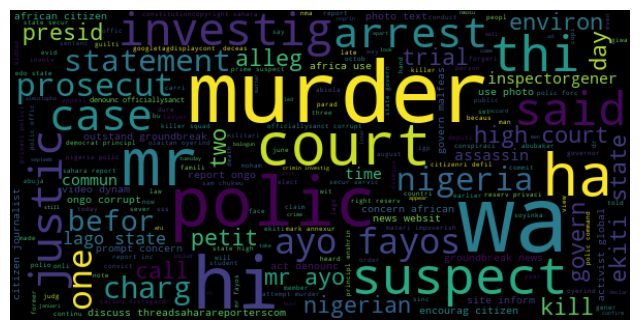

In [47]:
# visualizing which of the word is most commonly used for Murder crimes
Murder_words = ' '.join([text for text in df2['processed_news'][df2['label'] == 'Murder']])
wordcloud = WordCloud(width=600, height=300,random_state=21, max_font_size=90).generate(Murder_words)
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [48]:
pip install beautifulsoup4

In [50]:
pip install newspaper3k


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/7.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/7.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/7.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/7.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/7.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/7.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/7.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/7.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/7.4 MB ? eta -:--:--
      --------------------------------------- 0.1/7.4 MB 218.3 kB/s eta 0:00:34
      --------------------------------------- 0.1/7.4 MB 218.3 kB/s eta 0:00:34
      --------------------------------------- 0.1/7.4 MB 218.3 kB/s eta 0:00:34
      ------------

In [51]:
from newspaper import Article

In [56]:
url = 'http://fox13now.com/2013/12/30/new-year-new-laws-obamacare-pot-guns-and-drones/'
article = Article(url)

In [57]:
article.text

''